# Processing NetCFD files

this notebook show how to process the NetCFD files.

The files can be downloaded from the Google Drive link provided using the package `gdown`.


## List of files

There are 4 files in the dataset:
- `temperature.nc` : the 2m temperature in Kelvin
- `wind_spee.nc` : the 10m wind speed in m/s
- `sun_flux_downward.nc` : the downward surface solar flux in W/m^2
- `sun_flux_total.nc` : the total surface solar flux in W/m^2

The Sun flux total is not sampled at the same time as the other variables. It is sampled every 3 hours, while the other variables are sampled every hour.

## Variables and indexes

Each variables has 4 dimensions:
- `latitude` : the latitude of the location
- `longitude` : the longitude of the location
- `time` : the date at wich the forecast was made
- `step` : the number of hours in the future the forecast is made, relative to `time` 

The coordinate `valid_time` is the sum of `time` and `step`, and is the date at which the forecast is made.
The `valid_time` contains duplicates, as the forcast at time `t` and `t+1` with step `25h` and `1h` will have the same `valid_time`.

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from pathlib import Path

In [8]:
root = Path("/shared/home/antoine-2etavant/data/weather/")
list(root.glob("*.nc"))

[PosixPath('/shared/home/antoine-2etavant/data/weather/sun_flux_downward.nc'),
 PosixPath('/shared/home/antoine-2etavant/data/weather/sun_flux_total.nc'),
 PosixPath('/shared/home/antoine-2etavant/data/weather/wind_speed.nc'),
 PosixPath('/shared/home/antoine-2etavant/data/weather/temperature.nc')]

In [3]:
t2m = xr.open_dataset(root / "temperature.nc")
t2m

<xarray.Dataset> Size: 4GB
Dimensions:      (time: 772, step: 97, latitude: 97, longitude: 143)
Coordinates:
  * step         (step) timedelta64[ns] 776B 00:00:00 ... 4 days 00:00:00
  * latitude     (latitude) float64 776B 51.0 50.9 50.8 50.7 ... 41.6 41.5 41.4
  * longitude    (longitude) float64 1kB -4.7 -4.6 -4.5 -4.4 ... 9.2 9.3 9.4 9.5
  * time         (time) datetime64[ns] 6kB 2022-02-01 2022-02-02 ... 2024-04-08
    valid_time   (time, step) datetime64[ns] 599kB ...
Data variables:
    temperature  (time, step, latitude, longitude) float32 4GB ...

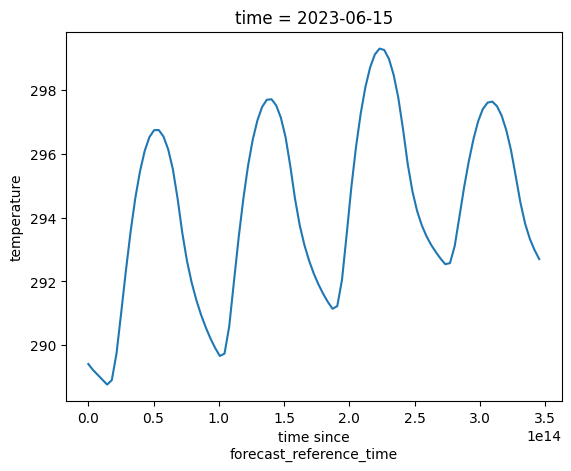

In [7]:
t2m.sel(time="2023-06-15").mean(dim=["latitude", "longitude"]).temperature.plot()

## Selecting J0 forecasts

The J0 forecasts are the forecasts made at the same time as the forecast is made. They are the forecasts with `step<1D`.

This will remove the duplicates in the `valid_time` coordinate.

In [9]:
t2m_J0 = t2m.where(t2m.step < pd.Timedelta(1, "D"), drop=True)
t2m_J0

<xarray.Dataset> Size: 1GB
Dimensions:      (time: 772, step: 24, latitude: 97, longitude: 143)
Coordinates:
  * step         (step) timedelta64[ns] 192B 00:00:00 01:00:00 ... 23:00:00
  * latitude     (latitude) float64 776B 51.0 50.9 50.8 50.7 ... 41.6 41.5 41.4
  * longitude    (longitude) float64 1kB -4.7 -4.6 -4.5 -4.4 ... 9.2 9.3 9.4 9.5
  * time         (time) datetime64[ns] 6kB 2022-02-01 2022-02-02 ... 2024-04-08
    valid_time   (time, step) datetime64[ns] 148kB ...
Data variables:
    temperature  (time, step, latitude, longitude) float32 1GB 283.3 ... 289.3

In [10]:
mask_regions = xr.load_dataarray("../../data/geo/mask_france_regions.nc")
mask_regions

<xarray.DataArray (longitude: 143, latitude: 97)> Size: 111kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * longitude  (longitude) float64 1kB -4.7 -4.6 -4.5 -4.4 ... 9.2 9.3 9.4 9.5
  * latitude   (latitude) float64 776B 51.0 50.9 50.8 50.7 ... 41.6 41.5 41.4

In [43]:
mean_regions_temperature = t2m_J0.temperature.groupby(mask_regions).mean()
mean_regions_temperature

<xarray.DataArray 'temperature' (time: 772, step: 24, group: 13)> Size: 963kB
array([[[273.7702 , 274.2465 , 273.20212, ..., 271.5214 , 273.74384,
         278.41068],
        [273.6992 , 274.04086, 272.8379 , ..., 270.88647, 273.0978 ,
         277.8415 ],
        [273.81998, 274.00867, 272.53165, ..., 270.44574, 272.63617,
         277.4004 ],
        ...,
        [281.59348, 280.97678, 276.72794, ..., 274.94403, 277.44998,
         276.97733],
        [281.67844, 281.06143, 277.0436 , ..., 275.20828, 277.66983,
         277.03726],
        [281.65363, 281.06406, 277.3134 , ..., 275.41138, 277.8039 ,
         277.28036]],

       [[282.1418 , 281.17514, 277.67694, ..., 275.3809 , 278.19406,
         277.3356 ],
        [281.7464 , 281.20572, 277.6942 , ..., 275.3877 , 278.20618,
         277.46048],
        [281.34338, 281.14932, 277.68347, ..., 275.44864, 278.43445,
         277.7052 ],
...
        [285.26788, 286.04163, 289.37982, ..., 287.96826, 284.96356,
         288.10724],
        [285.13492, 286.02185, 288.9827 , ..., 287.5748 , 284.55795,
         287.8836 ],
        [285.11838, 285.97412, 288.5551 , ..., 287.27835, 284.29437,
         287.60074]],

       [[285.13495, 284.60062, 288.0212 , ..., 286.37625, 283.70172,
         287.02267],
        [285.22775, 284.79913, 287.51843, ..., 285.99002, 283.56982,
         286.81485],
        [285.24878, 284.90692, 287.04868, ..., 285.77872, 283.4807 ,
         286.7235 ],
        ...,
        [286.20264, 283.36472, 288.87595, ..., 286.8166 , 287.37207,
         289.3932 ],
        [284.16245, 282.8211 , 287.60928, ..., 285.63486, 287.03787,
         289.14685],
        [282.96848, 282.64084, 286.08224, ..., 284.54922, 286.55368,
         288.89734]]], dtype=float32)
Coordinates:
  * step        (step) timedelta64[ns] 192B 00:00:00 01:00:00 ... 23:00:00
  * time        (time) datetime64[ns] 6kB 2022-02-01 2022-02-02 ... 2024-04-08
    valid_time  (time, step) datetime64[ns] 148kB ...
  * group       (group) float64 104B 0.0 1.0 2.0 3.0 4.0 ... 9.0 10.0 11.0 12.0
Attributes: (12/29)
    GRIB_paramId:                             167
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      386061
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_name:                                2 metre temperature
    GRIB_shortName:                           2t
    GRIB_units:                               K
    long_name:                                2 metre temperature
    units:                                    K
    standard_name:                            air_temperature

In [44]:
# remove valid_time coordinates because it doesn't work for some reason
mean_regions_temperature = mean_regions_temperature.drop_vars("valid_time")

In [45]:
import yaml

region_names = yaml.safe_load(open("../../data/geo/regions_name.yml"))
region_names

['Île-de-France',
 'Centre-Val de Loire',
 'Bourgogne-Franche-Comté',
 'Normandie',
 'Hauts-de-France',
 'Grand Est',
 'Pays de la Loire',
 'Bretagne',
 'Nouvelle-Aquitaine',
 'Occitanie',
 'Auvergne-Rhône-Alpes',
 "Provence-Alpes-Côte d'Azur",
 'Corse']

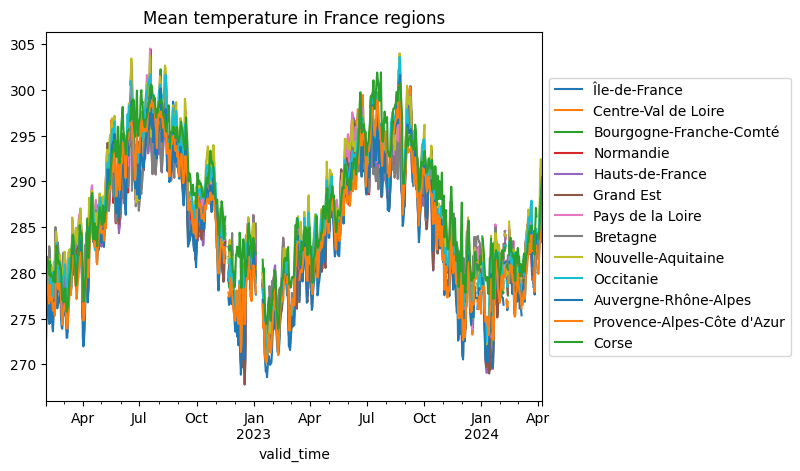

In [46]:
df_mean_region_temperature = mean_regions_temperature.to_dataframe().unstack()
df_mean_region_temperature.columns = df_mean_region_temperature.columns.droplevel()
df_mean_region_temperature.columns = region_names
df_mean_region_temperature["valid_time"] = (
    df_mean_region_temperature.index.get_level_values(0)
    + df_mean_region_temperature.index.get_level_values(1)
)
df_mean_region_temperature.set_index("valid_time", inplace=True)
ax = (
    df_mean_region_temperature.resample("D")
    .mean()
    .plot(title="Mean temperature in France regions")
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))